# Importing Packages 

In [1]:
#============ Importing Packages ============# 

#--------- Drawing Packages ---------#

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator, NullFormatter, LogLocator)
from set_size import set_size
from collections import Counter

#--------- Tensorflow Packages ---------#
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import f1_score
from sklearn.utils import class_weight
from tensorflow.keras.metrics import Metric
from sklearn.metrics import balanced_accuracy_score

#============== Packages for word2vec ==============#
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#============== Packages for classification ==============#
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.svm import SVC

#--------- Utilities Packages ---------#

import sys
print(sys.executable)
import os
import re
import pdb
import shelve
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, hstack
from tqdm import tqdm
from sklearn.utils import class_weight
import enchant

import nltk
import obspy

#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('word_tokenize')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.corpus import words as dict_w
from nltk.stem.porter import PorterStemmer

# Scipy Signal
from scipy import signal

# Detrend the Signal
from obspy.signal.detrend import polynomial

#--------- Remove Warnings ---------#
import warnings
warnings.filterwarnings("ignore")


/home/chiangwe/anaconda3/envs/NetHawkes/bin/python


In [4]:
#========= Read in =========#

df = pd.read_csv('Eluvio_DS_Challenge_processes.csv')
#display( df.sort_values('up_votes', ascending=False).head(5)['title'].values )

class_weights = class_weight.compute_class_weight('balanced',  np.unique(df['label']), df['label'])
class_weights = dict(zip( np.unique(df['label']), class_weights))


df = df[ df['title_clean'].apply(lambda x: type(x)==str) ] 
y_true = df['label']

embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50/2")
X_train_in = embed(df['title'].values).numpy()


In [3]:
from sklearn.cluster import MiniBatchKMeans

X_in = np.hstack((X_train_in, np.expand_dims(df['up_votes'].values, axis= 1)))
X_in = (X_in-X_in.mean(0))/X_in.std(0)

labels = []; indexs = []

for cls_first in [3, 5, 10]:
    
    kmeans_first  = MiniBatchKMeans(n_clusters=cls_first,random_state=0,batch_size=30)
    kmeans_first = kmeans_first.partial_fit( X_in )
    k_first = kmeans_first.labels_;
    
    for cls_second in [5, 10, 15, 20]: 
        tol_label = []; tol_index = []
        
        for k_iter in range(0, cls_first):
            
            indx_level_01 = np.where(k_first==k_iter)[0]
            X_in_sec = X_in[ indx_level_01, : ]
            
            kmeans   = MiniBatchKMeans(n_clusters=cls_second,random_state=0,batch_size=30)
            kmeans   = kmeans.partial_fit( X_in_sec )
            k_second = kmeans.labels_;
            k_second = k_second + k_iter*cls_second;
            
            tol_index.append( indx_level_01 )
            tol_label.append( k_second )
            
        tol_index = np.hstack(tol_index)
        tol_label = np.hstack(tol_label)
        
        labels.append(tol_label); 
        indexs.append(tol_index); 


In [4]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

score = [];


for each_label, each_index in tqdm( zip(labels, indexs) ):
    X_re = X_in[each_index, :];
    n_cls = np.max(each_label)
    
    df_label = pd.DataFrame(each_label, columns=['label'])
    df_label['idx'] = df_label.index
    
    ls_silh=[]; ls_cal=[]; ls_dav=[];
    for itr in range(0, 3):
        df_sample = df_label.groupby('label').sample(frac=0.01, random_state=itr)
    
        same_idx = df_sample['idx'].values;
        same_label = df_sample['label'].values
    
        silh = silhouette_score( X_re[same_idx, :], same_label)
        cal = calinski_harabasz_score( X_re[same_idx, :], same_label)
        dav = davies_bouldin_score( X_re[same_idx, :], same_label)
        
        ls_silh.append(silh); ls_cal.append(cal); ls_dav.append(dav)
    score.append( (n_cls, np.mean(ls_silh), np.mean(ls_cal), np.mean(ls_dav)) )

print(score)


12it [00:18,  1.57s/it]

[(14, 0.011434581397000184, 89.026092706208019, 4.5126414748791435), (29, 0.0079000812757269289, 53.614150846601866, 4.4336089639381173), (44, 0.0068533446191635025, 41.39692825677858, 4.1110428059394701), (59, 0.0052345610005762695, 33.629888232220573, 4.0302870742552672), (24, 0.010491227858676842, 61.106836686042925, 4.4303794339745748), (49, 0.0047558711441782068, 36.736467908510271, 4.2747745992100548), (74, 0.0011326893273863818, 27.446613185974371, 3.9993030975187143), (99, 0.00014627825718759317, 22.556105444807812, 3.8111494242727826), (49, 0.0055025765403495727, 37.705510941795914, 4.4141563478144095), (99, -0.00037764998102641909, 22.280616317203812, 3.973504298210067), (149, -0.0036075296416892486, 16.532712838342636, 3.7551781658338528), (199, -0.0076030351310891935, 13.475033681457168, 3.5572171165444986)]


In [5]:
score = pd.DataFrame(score, columns=['ncls', 'silh','cal','dav'])
score['method'] = 'Emb_nnlm'
display(score)
score.to_csv('score_Emb_nnlm.csv', index=False)

,ncls,silh,cal,dav,method
0,14,0.011435,89.026093,4.512641,Emb_nnlm
1,29,0.007900,53.614151,4.433609,Emb_nnlm
2,44,0.006853,41.396928,4.111043,Emb_nnlm
3,59,0.005235,33.629888,4.030287,Emb_nnlm
4,24,0.010491,61.106837,4.430379,Emb_nnlm
5,49,0.004756,36.736468,4.274775,Emb_nnlm
6,74,0.001133,27.446613,3.999303,Emb_nnlm
7,99,0.000146,22.556105,3.811149,Emb_nnlm
8,49,0.005503,37.705511,4.414156,Emb_nnlm
9,99,-0.000378,22.280616,3.973504,Emb_nnlm


In [5]:
## USE HOSTLGRAM

#========= TDIDF =========#

#print(  df['title_clean'].apply(lambda x: type(x)!=str ).sum()  )
bow_converter = CountVectorizer()
x = bow_converter.fit_transform(df['title_clean'])

words = bow_converter.get_feature_names()

bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2]) 
trigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3])

tfidf_transform = TfidfTransformer(norm=None)
X_tfidf = tfidf_transform.fit_transform(x)

X_tfidf = normalize(X_tfidf,axis=1)

#========= ===  =========#


In [6]:
from sklearn.cluster import MiniBatchKMeans

X_in = np.hstack((X_train_in, np.expand_dims(df['up_votes'].values, axis= 1)))
X_in = (X_in-X_in.mean(0))/X_in.std(0)

labels = []; indexs = []

for cls_first in [3, 5, 10]:
    
    kmeans_first  = MiniBatchKMeans(n_clusters=cls_first,random_state=0,batch_size=3)
    kmeans_first = kmeans_first.partial_fit( X_in )
    k_first = kmeans_first.labels_;
    
    for cls_second in [5, 10, 15, 20]: 
        tol_label = []; tol_index = []
        
        for k_iter in range(0, cls_first):
            
            indx_level_01 = np.where(k_first==k_iter)[0]
            X_in_sec = X_in[ indx_level_01, : ]
            
            kmeans   = MiniBatchKMeans(n_clusters=cls_second,random_state=0,batch_size=30)
            kmeans   = kmeans.partial_fit( X_in_sec )
            k_second = kmeans.labels_;
            k_second = k_second + k_iter*cls_second;
            
            tol_index.append( indx_level_01 )
            tol_label.append( k_second )
            
        tol_index = np.hstack(tol_index)
        tol_label = np.hstack(tol_label)
        
        labels.append(tol_label); 
        indexs.append(tol_index); 


In [7]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

score_tfidf = [];


for each_label, each_index in tqdm( zip(labels, indexs) ):
    X_re = X_in[each_index, :];
    n_cls = np.max(each_label)
    
    df_label = pd.DataFrame(each_label, columns=['label'])
    df_label['idx'] = df_label.index
    
    ls_silh=[]; ls_cal=[]; ls_dav=[];
    for itr in range(0, 3):
        df_sample = df_label.groupby('label').sample(frac=0.01, random_state=itr)
    
        same_idx = df_sample['idx'].values;
        same_label = df_sample['label'].values
    
        silh = silhouette_score( X_re[same_idx, :], same_label)
        cal = calinski_harabasz_score( X_re[same_idx, :], same_label)
        dav = davies_bouldin_score( X_re[same_idx, :], same_label)
        
        ls_silh.append(silh); ls_cal.append(cal); ls_dav.append(dav)
    score_tfidf.append( (n_cls, np.mean(ls_silh), np.mean(ls_cal), np.mean(ls_dav)) )

print(score_tfidf)


12it [00:19,  1.59s/it]

[(14, 0.020511052550565716, 86.681706354845346, 4.3310229800288473), (29, 0.0088734162718476523, 55.452727300852615, 4.2267906790687135), (44, 0.0069080032275794572, 41.267699433173298, 4.1003578739466393), (59, 0.0048459338726652796, 33.445167293949375, 4.0335296252649293), (24, 0.0091303005859837746, 60.929502041992343, 4.280846073390169), (49, 0.0022174640260295589, 36.65644829084777, 4.0184133864469311), (74, 0.00046433133790075356, 27.514467574205327, 3.963512171004703), (99, 0.00055572746222635723, 22.479998528834646, 3.8269067535720569), (49, 0.0067194578667367525, 36.717666521926674, 4.3617544085084425), (99, -0.00094517463616702586, 21.885240769646838, 3.965046716810996), (149, -0.0055310518027531924, 16.292387035399006, 3.7609027438467102), (199, -0.0089983571263599835, 13.227753835901238, 3.5239859412366807)]


In [8]:
score_tfidf = pd.DataFrame(score_tfidf, columns=['ncls', 'silh','cal','dav'])
score_tfidf['method'] = 'TfIdf'
score_tfidf.to_csv('score_TfIdf.csv', index=False)
display(score_tfidf)

,ncls,silh,cal,dav,method
0,14,0.020511,86.681706,4.331023,TfIdf
1,29,0.008873,55.452727,4.226791,TfIdf
2,44,0.006908,41.267699,4.100358,TfIdf
3,59,0.004846,33.445167,4.033530,TfIdf
4,24,0.009130,60.929502,4.280846,TfIdf
5,49,0.002217,36.656448,4.018413,TfIdf
6,74,0.000464,27.514468,3.963512,TfIdf
7,99,0.000556,22.479999,3.826907,TfIdf
8,49,0.006719,36.717667,4.361754,TfIdf
9,99,-0.000945,21.885241,3.965047,TfIdf


In [9]:
score_tfidf = pd.read_csv('score_TfIdf.csv')
score_Emb_nnlm = pd.read_csv('score_Emb_nnlm.csv')

score = pd.concat([score_tfidf, score_Emb_nnlm]).reset_index()

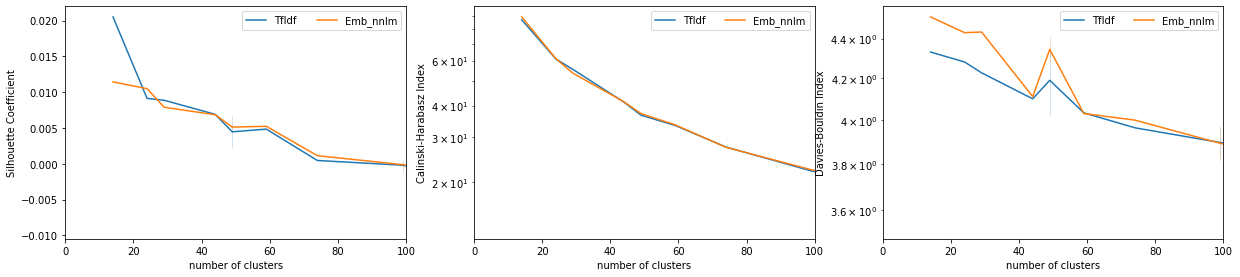

In [10]:
from set_size import set_size
width =3000.0
clr_palette = sns.color_palette()
#
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=set_size(width, height_adjust=1, fraction=0.5, subplots=(1,3 )))


sns.lineplot(data=score, x='ncls', y='silh', hue="method", ax=ax1)
ax1.set_xlim(0, 100)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('Silhouette Coefficient')
ax1.legend(ncol=2, title=None)
#
sns.lineplot(data=score, x='ncls', y='cal', hue="method", ax=ax2)
ax2.set_xlim(0, 100)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('Calinski-Harabasz Index')
ax2.set_yscale('log')
ax2.legend(ncol=2, title=None)
#
g = sns.lineplot(data=score, x='ncls', y='dav', hue="method", ax=ax3)
ax3.set_xlim(0, 100)
ax3.set_xlabel('number of clusters')
ax3.set_ylabel('Davies-Bouldin Index')
ax3.set_yscale('log')
ax3.legend(ncol=2, title=None)


In [11]:
from sklearn.manifold import TSNE

each_label = labels[0]
each_index = indexs[0]

X_re = X_in[each_index, :];
n_cls = np.max(each_label)

df_label = pd.DataFrame(each_label, columns=['label'])
df_label['idx'] = df_label.index

ls_silh=[]; ls_cal=[]; ls_dav=[];

itr = 0
df_sample = df_label.groupby('label').sample(frac=0.01, random_state=itr)

same_idx = df_sample['idx'].values;
same_label = df_sample['label'].values

sp_dw_app_keep = X_re[same_idx, :]

#============ Tsne ============#
X_sample_tr      = sp_dw_app_keep;     
X_sample_tr_tsne = TSNE(n_components=2, perplexity=1000, random_state=123).fit_transform( X_sample_tr )
X_sample_tr_tsne = normalize(X_sample_tr_tsne, axis=0)
#==============================#

#=== Plot ===#
#width = 1000.0
#fig2, ax2 = plt.subplots(1, 1, figsize=set_size(width, height_adjust=1, fraction=1, subplots=(1, 1)))
print(np.unique(same_label).shape[0])
clr_palette_tsne = sns.color_palette("husl", np.unique(same_label).shape[0] )
data_plt_tsne = pd.DataFrame({'x_axis': X_sample_tr_tsne[:, 0], 'y_axis': X_sample_tr_tsne[:, 1], 'label': same_label}) 

15


[ 0  0  0 ..., 14 14 14]


<AxesSubplot:xlabel='x_axis', ylabel='y_axis'>

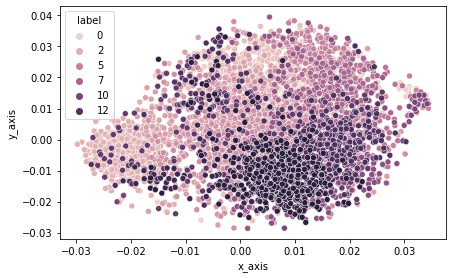

In [12]:
#print(np.max(np.unique(same_label)))
#clr_palette_tsne = sns.color_palette("husl", 0 )
print((same_label))
data_plt_tsne = pd.DataFrame({'x_axis': X_sample_tr_tsne[:, 0], 'y_axis': X_sample_tr_tsne[:, 1], 'label': same_label}) 

width = 500.0
fig2, ax2 = plt.subplots(1, 1, figsize=set_size(width, height_adjust=1, fraction=1, subplots=(1, 1)))

sns.scatterplot(data=data_plt_tsne, x="x_axis", y="y_axis", hue="label", ax=ax2)

In [13]:
#======= Recommendation Modeling ================#
each_label = labels[2]
each_index = indexs[2]
print(each_label.shape)
print(df.shape)
df_rec = df.iloc[each_index,:]


(504717,)
(504717, 11)


In [14]:
df_rec['category'] = each_label;
#display(df_rec)
df_cat_cnt = df_rec.groupby('author').apply(lambda x: np.unique(x['category']).shape[0]).sort_values(ascending=False);


In [40]:
authors = list(df_cat_cnt[df_cat_cnt>10].index) 
#print(df_rec.index)
df_rec_sel = df_rec.reset_index(drop=True)
df_rec_sel = df_rec_sel[df_rec_sel['author'].isin(authors)]

from scipy.sparse import coo_matrix, hstack
X_tfidf_sel = X_tfidf[list(df_rec_sel.index),:]
#display(hstack([coo_matrix(X_tfidf_sel), coo_matrix(df_rec_sel['up_votes'])]))

In [43]:
cat_author = df_rec_sel.groupby(['author','category']).size()

In [51]:
ls_author = cat_author.reset_index()['author'].drop_duplicates().values.tolist()
ls_cat = cat_author.reset_index()['category'].drop_duplicates().values.tolist()

In [54]:
ls_author
ls_cat
dict_author = dict(zip(ls_author, range(0, len(ls_author))))
dict_cat= dict(zip(ls_cat, range(0, len(ls_cat))))
display(cat_author.reset_index())

author   category
--Kai--  1           1
         3           1
         4           4
         7           1
         8           3
                    ..
zzybert  33          3
         34          2
         42          2
         43          2
         44          1
Length: 76696, dtype: int64

In [72]:
row = [ dict_author[each] for each in cat_author.reset_index()['author']]
col = [ dict_cat[each] for each in cat_author.reset_index()['category']]
data = [ each for each in cat_author.reset_index()[0]]
user_mat = csr_matrix((data, (row, col)), shape=(len(ls_author), len(ls_cat)))
display(user_mat.sum(1).mean())

83.918485076498627

In [73]:
np.random.seed(123)
hold_out_cat = []
for each_user in range(0, len(ls_author)):
    cand = np.where( user_mat[each_user, :].todense() != 0)[1]
    sel = np.random.choice(cand, 1)
    #print(each_user, sel, user_mat[each_user, sel])
    user_mat[each_user, sel] = 0
    #print(each_user, sel, user_mat[each_user, sel])
    hold_out_cat.append(sel)
display(user_mat.sum(1).mean())

80.828191622774014

In [75]:
from sklearn.linear_model import LinearRegression
ls_clf = []

for each_cat in range(0, len(ls_cat) ):
    sel_dim = np.setdiff1d( np.arange(0, user_mat.shape[1]), each_cat)
    X = user_mat[:, sel_dim]
    y = user_mat[:, each_cat]
    reg = LinearRegression().fit(X, y.todense())
    ls_clf.append(reg)

In [80]:
all_score = np.zeros((len(ls_author), len(ls_cat)))
for each_cat in range(0, len(ls_cat) ):
    sel_dim = np.setdiff1d( np.arange(0, user_mat.shape[1]), each_cat)
    
    reg = ls_clf[each_cat]
    X = user_mat[:, sel_dim]
    score = reg.predict(X )
    all_score[:, each_cat:each_cat+1] = score;
    

In [99]:
display(user_mat.todense())
score_mod = (user_mat>0) * (-np.inf) + all_score
#print(score_mod)
index = np.argsort(score_mod, 1)[:, ::-1]

print(index[:, 0:20])
print(np.hstack(hold_out_cat))

matrix([[ 1,  1,  4, ...,  0,  0,  0],
        [ 2,  5,  7, ...,  0,  0,  0],
        [ 0,  8,  0, ...,  0,  0,  0],
        ..., 
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  1,  1, ...,  0,  0,  0],
        [ 3, 12,  0, ...,  0,  1,  0]], dtype=int64)

[[17 35 22 ..., 24 25 38]
 [ 9 16  7 ..., 11 10  3]
 [ 0 38  2 ..., 30 29 26]
 ..., 
 [16 34  2 ..., 14 41 31]
 [34  0 20 ..., 11 38 13]
 [10 40 15 ..., 20  4 38]]
[14 16  4 ..., 28 32  9]


In [106]:
#===== HIT RATE 
for hitk in [3, 5, 10]:
    hitornot= [];
    cad = index[:, 0:hitk]
    for user in range(0, len(ls_author)):
        if np.hstack(hold_out_cat)[user] in cad[user, :].tolist()[0]:
            hitornot.append(  1/(np.where(cad[user, :].tolist()[0]==np.hstack(hold_out_cat)[user])[0]+1))
    print(np.sum(hitornot)/ len(ls_author))

0.362845915893
0.386460162194
0.40677728411


In [108]:
from sklearn.decomposition import NMF
row = [ dict_author[each] for each in cat_author.reset_index()['author']]
col = [ dict_cat[each] for each in cat_author.reset_index()['category']]
data = [ each for each in cat_author.reset_index()[0]]
user_mat = csr_matrix((data, (row, col)), shape=(len(ls_author), len(ls_cat)))
display(user_mat.sum(1).mean())

np.random.seed(123)
hold_out_cat = []
for each_user in range(0, len(ls_author)):
    cand = np.where( user_mat[each_user, :].todense() != 0)[1]
    sel = np.random.choice(cand, 1)
    #print(each_user, sel, user_mat[each_user, sel])
    user_mat[each_user, sel] = 0
    #print(each_user, sel, user_mat[each_user, sel])
    hold_out_cat.append(sel)
display(user_mat.sum(1).mean())


83.918485076498627

80.828191622774014

In [111]:
model = NMF(n_components=20, init='random', random_state=0)
W = model.fit_transform(user_mat.todense())
H = model.components_

In [116]:
display(W.shape)
display(H.shape)

MF_BACK = np.matrix(W)* np.matrix(H)

display(user_mat.todense())
score_mod = (user_mat>0) * (-np.inf) + MF_BACK
#print(score_mod)
index = np.argsort(score_mod, 1)[:, ::-1]

print(index[:, 0:20])
print(np.hstack(hold_out_cat))


(3987, 20)

(20, 45)

matrix([[ 1,  1,  4, ...,  0,  0,  0],
        [ 2,  5,  7, ...,  0,  0,  0],
        [ 0,  8,  0, ...,  0,  0,  0],
        ..., 
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  1,  1, ...,  0,  0,  0],
        [ 3, 12,  0, ...,  0,  1,  0]], dtype=int64)

[[25 22 15 ..., 30 33 14]
 [ 9  7 35 ..., 11 10  3]
 [33  9 38 ..., 11 43 39]
 ..., 
 [16 24 28 ..., 14  4 35]
 [ 3 20 15 ..., 32 43 11]
 [10  6 15 ..., 20 17 44]]
[14 16  4 ..., 28 32  9]


In [117]:
#===== HIT RATE 
for hitk in [3, 5, 10]:
    hitornot= [];
    cad = index[:, 0:hitk]
    for user in range(0, len(ls_author)):
        if np.hstack(hold_out_cat)[user] in cad[user, :].tolist()[0]:
            hitornot.append(  1/(np.where(cad[user, :].tolist()[0]==np.hstack(hold_out_cat)[user])[0]+1))
    print(np.sum(hitornot)/ len(ls_author))

0.232881866065
0.260057687484
0.286341124528


In [119]:
#===== HIT RATE 
for hitk in [3, 5, 10]:
    hitornot= [];
    cad = index[:, 0:hitk]
    for user in range(0, len(ls_author)):
        if np.hstack(hold_out_cat)[user] in cad[user, :].tolist()[0]:
            hitornot.append(  True)
            #hitornot.append(  1/(np.where(cad[user, :].tolist()[0]==np.hstack(hold_out_cat)[user])[0]+1))
    print(np.sum(hitornot)/ len(ls_author))

0.320290945573
0.440431402057
0.639077000251


In [118]:
from sklearn.decomposition import NMF
row = [ dict_author[each] for each in cat_author.reset_index()['author']]
col = [ dict_cat[each] for each in cat_author.reset_index()['category']]
data = [ each for each in cat_author.reset_index()[0]]
user_mat = csr_matrix((data, (row, col)), shape=(len(ls_author), len(ls_cat)))
display(user_mat.sum(1).mean())

np.random.seed(123)
hold_out_cat = []
for each_user in range(0, len(ls_author)):
    cand = np.where( user_mat[each_user, :].todense() != 0)[1]
    sel = np.random.choice(cand, 1)
    #print(each_user, sel, user_mat[each_user, sel])
    user_mat[each_user, sel] = 0
    #print(each_user, sel, user_mat[each_user, sel])
    hold_out_cat.append(sel)
display(user_mat.sum(1).mean())


83.918485076498627

80.828191622774014

In [ ]:
### Try Google trends